## Acquire images

This notebook will:

* Section 1: For a given bounding box and year, find all SAR images in that region. Get some stats on them
* Section 2: Filter out images from scenes that don't have sufficient preceding winter imagery for melt detection
* Section 3: Run ASF Hyp3 RTC processing
* Section 4: Download the data. Reproject it immedately and save only the smaller image. Does that work? I thought I would have to have EPSG vals? This will have to get figured out

### Preamble
Prepare to do stuff

In [2]:
import url_widget as url_w
notebookUrl = url_w.URLWidget()
display(notebookUrl)

notebookUrl = notebookUrl.value
user = !echo $JUPYTERHUB_USER
env = !echo $CONDA_PREFIX

#capture
from datetime import datetime
import glob
import json # for loads
import os
from pathlib import Path
import pytz
import re
import shutil
import asf_search as asf
from zipfile import ZipFile
import time
import fnmatch

from matplotlib import pyplot as plt
#Writing Support Functions:

import numpy as np
from osgeo import gdal,osr

from IPython.display import HTML, display, clear_output, Markdown
    
from hyp3_sdk import Batch, HyP3

import opensarlab_lib as asfn

URLWidget()

In [16]:
##NAME PROJECT###
projdir = Path.home()/"GlacierSARdata"
projname = 'Juneau'
year = 2021
data_dir=Path(f'{projdir}/{projname}/{str(year)}')
pols = ['VV','VH']

# Setting Paths
analysis_directory = Path.cwd()/data_dir
print(f"analysis_directory: {analysis_directory}")

download_path = analysis_directory/"rtc_download"
# download_path.mkdir()
products_path = analysis_directory/"rtc_products"
# products_path.mkdir()
clipped_path = analysis_directory/"rtc_clipped"

print(download_path)
print(products_path)
print(clipped_path)

os.makedirs(data_dir,exist_ok=True)
os.makedirs(download_path,exist_ok=True)
os.makedirs(products_path,exist_ok=True)
os.makedirs(analysis_directory/"figures",exist_ok=True)
os.makedirs(clipped_path,exist_ok=True)
for pol in pols:
    os.makedirs(clipped_path/pol,exist_ok=True)

# print(os.path.exists(data_dir))

analysis_directory: /home/jovyan/GlacierSARdata/Juneau/2021
/home/jovyan/GlacierSARdata/Juneau/2021/rtc_download
/home/jovyan/GlacierSARdata/Juneau/2021/rtc_products
/home/jovyan/GlacierSARdata/Juneau/2021/rtc_clipped


In [8]:
# def timediff(time1,time2,form='seconds'):
#     '''time difference between time2 and time1 expressed as either days or seconds'''
#     # dd = 1
#     # if time1>time2:
#     #     dd=1
#     diff = time2-time1
#     if form=='seconds':
#         diff = diff.seconds+diff.days*86400
#     elif form=='days':
#         diff = diff.seconds/86400+diff.days
#     return diff

## Find SAR Images

Find the SAR images, run some statistics on their frequency, and queue them for Hyp3 processing

In [17]:
#testpolygon = POLYGON((-143.1356 61.7756,-143.3698 61.7793,-143.5279 61.7044,-143.3824 61.6052,-143.0614 61.4737,-142.9854 61.4144,-142.804 61.4292,-142.7358 61.5912,-142.5978 61.6494,-142.6707 61.7523,-142.9699 61.7839,-143.1356 61.7756))
# WTKstr='POLYGON((-143.4858 61.4239,-142.5307 61.4239,-142.5307 61.7757,-143.4858 61.7757,-143.4858 61.4239))' #Kennicott
# WTKstr='POLYGON((-144.5124 61.8108,-143.2512 61.8108,-143.2512 62.1938,-144.5124 62.1938,-144.5124 61.8108))' #Mt Wrangell
# WTKstr='POLYGON((-151.6946 62.7583,-150.1696 62.7583,-150.1696 63.2668,-151.6946 63.2668,-151.6946 62.7583))' #Denali_h (mostly higher elevations)
# WTKstr='POLYGON((-150.6448 59.6467,-149.5491 59.6467,-149.5491 60.2703,-150.6448 60.2703,-150.6448 59.6467))' #Harding
WTKstr='POLYGON((-134.7796 58.3698,-133.5 58.3698,-133.5 59.109,-134.7796 59.109,-134.7796 58.3698))' #Juneau
# testWTK='POLYGON((-134.5463 58.5889,-133.8663 58.5889,-133.8663 58.7656,-134.5463 58.7656,-134.5463 58.5889))' #SE AK icefield
# testWTK='POLYGON((-18.2664 63.9706,-15.2442 63.9706,-15.2442 64.9461,-18.2664 64.9461,-18.2664 63.9706))' #iceland
# testWTK='POLYGON((15.123 78.0197,16.9688 78.0197,16.9688 78.2449,15.123 78.2449,15.123 78.0197))' #svalbard
# testWTK = 'POLYGON((-140.264 60.3786,-140.0853 60.3786,-140.0853 60.4539,-140.264 60.4539,-140.264 60.3786))'
# testWTK='POLYGON((-50.0733 70.6347,-47.6859 70.6347,-47.6859 71.1109,-50.0733 71.1109,-50.0733 70.6347))' #west greenland

#test thing
#test thing 2
# year = 2021
# results = asf.geo_search(platform=[asf.PLATFORM.SENTINEL1], intersectsWith=WTKstr, maxResults=1000,start=f'{year}-01-01',
#                          end=f'{year+1}-01-01',processingLevel='SLC')

# datelist = []
# pflist = [] #path-frame list
# for res in results:
#     res = res.properties
#     rdate = datetime.strptime(res['startTime'],'%Y-%m-%dT%H:%M:%S.%f')
#     rpf = res['pathNumber']+'-'+res['frameNumber']
#     res['datetime']=rdate
#     res['pfval'] = rpf
#     datelist.append(rdate)
#     pflist.append(rpf)

    
# pfunique = np.unique(pflist)
# pfvals = pflist
# pflist = [np.where(pfunique==i)[0][0] for i in pflist]

# plt.figure()
# plt.plot(datelist,pflist,'.',markersize=12)

In [17]:
# help(results[0])
# results[0].properties

In [31]:
# #remove images that have less than N winter scenes

# N=4
# wstart = datetime(year,1,1,0,0,0)
# wend = datetime(year,4,1,1,0,0,0)
# #result2 = results
# pfremove=[]
# trem = 0
# #identify path-frames that do not meet requirements
# for pf in pfunique:
#     eles = [i for i in results if i.properties['pfval']==pf]
#     datelist = np.array([i.properties['datetime'] for i in eles])
#     dl2 = datelist[datelist > wstart]
#     dl2 = dl2[dl2 < wend]
#     if len(dl2)<N:
#         pfremove.append(pf)
#         trem += len(datelist)

# #remove images from those path-frames
# for res in results:
#     if res.properties['pfval'] in pfremove:
#         results.remove(res)
            
# print(f'total removed: {trem}')
# # print(pfremove)

# #now plot again:
# datelist = [i.properties['datetime'] for i in results]
# pflist = [i.properties['pfval'] for i in results]
# pfunique = np.unique(pflist)
# pflist = [np.where(pfunique==i)[0][0] for i in pflist]

# plt.figure()
# plt.plot(datelist,pflist,'.',markersize=12)

In [15]:
#Give more stats:

# dlsort = [i for i in datelist]
# dlsort.sort()
# dldelta = [timediff(dlsort[i],dlsort[i+1],form='days') for i in range(len(dlsort)-1)]
# dldelta = np.array(dldelta)

# print('Acquisition stats')
# print(f'Number of acquisitions:       {len(dldelta)+1}')
# print(f'Number of images >1min apart: {len(dldelta[dldelta>1/1440])+1}\n')
# print(f'Mean days apart:   {np.mean(dldelta):.3f}')
# print(f'Mean days >1min:   {np.mean(dldelta[dldelta>1/1440]):.3f}')
# print(f'Median days apart: {np.median(dldelta):.3f}')
# print(f'Median days >1min: {np.median(dldelta[dldelta>1/1440]):.3f}')
# print(f'Stdev days apart:  {np.std(dldelta):.3f}')
# print(f'Longest gap:       {np.max(dldelta):.3f}')
# print('Note: these are over the whole area, not necessarily by pixel')

In [6]:
#funcs for this kind of thing:

def timediff(time1,time2,form='seconds'):
    '''time difference between time2 and time1 expressed as either days or seconds'''
    # dd = 1
    # if time1>time2:
    #     dd=1
    diff = time2-time1
    if form=='seconds':
        diff = diff.seconds+diff.days*86400
    elif form=='days':
        diff = diff.seconds/86400+diff.days
    return diff

def getasfresults(WTKstr,year,trimresults=True,winterN=4,showplots=False,showstats=False):
    """trim results removes images if there are less than winterN number of winter scenes to establish the baseline"""
    results = asf.geo_search(platform=[asf.PLATFORM.SENTINEL1], intersectsWith=WTKstr, maxResults=1000,start=f'{str(year)}-01-01',
                         end=f'{str(year+1)}-01-01',processingLevel='SLC')

    datelist = []
    pflist = [] #path-frame list
    for res in results:
        res = res.properties
        rdate = datetime.strptime(res['startTime'],'%Y-%m-%dT%H:%M:%S.%f')
        rpf = res['pathNumber']+'-'+res['frameNumber']
        res['datetime']=rdate
        res['pfval'] = rpf
        datelist.append(rdate)
        pflist.append(rpf)


    pfunique = np.unique(pflist)
    pfvals = pflist
    pflist = [np.where(pfunique==i)[0][0] for i in pflist]
    
    if showplots==True:
        plt.figure()
        plt.plot(datelist,pflist,'.',markersize=12)
        
    if trimresults==True:
        wstart = datetime(year,1,1,0,0,0)
        wend = datetime(year,4,1,1,0,0,0)
        #result2 = results
        pfremove=[]
        trem = 0
        #identify path-frames that do not meet requirements
        for pf in pfunique:
            eles = [i for i in results if i.properties['pfval']==pf]
            datelist = np.array([i.properties['datetime'] for i in eles])
            dl2 = datelist[datelist > wstart]
            dl2 = dl2[dl2 < wend]
            if len(dl2)<winterN:
                pfremove.append(pf)
                trem += len(datelist)

        #remove images from those path-frames
        for res in results:
            if res.properties['pfval'] in pfremove:
                results.remove(res)

        print(f'total removed: {trem}')
        # print(pfremove)
        
        #now plot again:
        datelist = [i.properties['datetime'] for i in results]
        pflist = [i.properties['pfval'] for i in results]
        pfunique = np.unique(pflist)
        pflist = [np.where(pfunique==i)[0][0] for i in pflist]

        if showplots==True:
            plt.figure()
            plt.plot(datelist,pflist,'.',markersize=12)
        
    if showstats==True:
        dlsort = [i for i in datelist]
        dlsort.sort()
        dldelta = [timediff(dlsort[i],dlsort[i+1],form='days') for i in range(len(dlsort)-1)]
        dldelta = np.array(dldelta)

        print('Acquisition stats')
        print(f'Number of acquisitions:       {len(dldelta)+1}')
        print(f'Number of images >1min apart: {len(dldelta[dldelta>1/1440])+1}\n')
        print(f'Mean days apart:   {np.mean(dldelta):.3f}')
        print(f'Mean days >1min:   {np.mean(dldelta[dldelta>1/1440]):.3f}')
        print(f'Median days apart: {np.median(dldelta):.3f}')
        print(f'Median days >1min: {np.median(dldelta[dldelta>1/1440]):.3f}')
        print(f'Stdev days apart:  {np.std(dldelta):.3f}')
        print(f'Longest gap:       {np.max(dldelta):.3f}')
        print('Note: these are over the whole area, not necessarily by pixel')
        
    return results

In [28]:
# results = getasfresults(WTKstr,year,showplots=True,showstats=True)
# print(len(results))

## Do Hyp3 Processing

I need to:

1. Identify all the images you want DONE
2. Check if any of those are already RTC processed (not expired)
3. Process all the remaining jobs
4. Make a hyp3 object for the full list of jobs, with those done via new process and those done via old process
5. download, extract, convert, and clip from those jobs

In [7]:
hyp3 = HyP3(prompt=True)

NASA Earthdata Login username:  acjohnson16
NASA Earthdata Login password:  ·········


In [ ]:
# readyproducts[10].job_parameters['granules']
# readyproducts[10]#.job_parameters['expiration_time']
# print(readyproducts[10].expiration_time)
newproducts= hyp3.find_jobs(name='Wrangell_19')

In [34]:
# granp = newproducts[0].job_parameters['granules'][0]
# print(newproducts[0])
# newproducts[0]
# print(granp)
# print(dojobs[-1].properties['sceneName'])
# granp in readyprodnames
# dojobs[-1].properties['sceneName'] in readyprodnames
# incount = [1 for i in readyprodnames if i in resultnames]
# print(np.sum(incount))
# len(readyprodnames)
# resultnames[-2] in readyprodnames

print(len(results))
results.remove(results[0])
print(len(results))

129
128


total removed: 0
Acquisition stats
Number of acquisitions:       116
Number of images >1min apart: 87

Mean days apart:   3.070
Mean days >1min:   4.105
Median days apart: 4.480
Median days >1min: 4.480
Stdev days apart:  2.978
Longest gap:       11.474
Note: these are over the whole area, not necessarily by pixel
total removed: 0
jobs already ready: 116
Number of jobs to do: 0


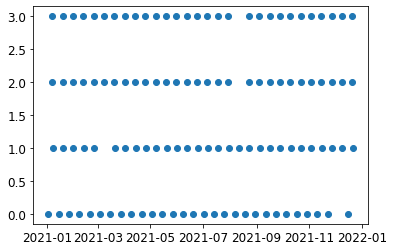

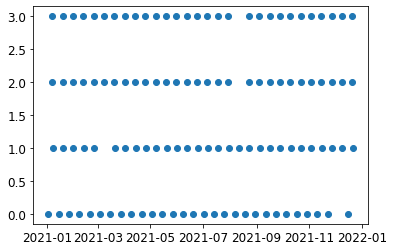

In [18]:
#Get_Data

# readyproducts = hyp3.find_jobs(name="Wrangell_19")
readyproducts = hyp3.find_jobs()
readyproducts = readyproducts.filter_jobs(succeeded=True,include_expired=False)
readyprodnames = [i.job_parameters['granules'][0] for i in readyproducts]
# print(len(readyproducts))

results = getasfresults(WTKstr,year,showplots=True,showstats=True)
dojobs = getasfresults(WTKstr,year)
resultnames = [i.properties['sceneName'] for i in results]

# print('job count')
# print(len(dojobs))
# print(len(results))
remcount = 0
# othercount = 0
for i,job in enumerate(results):
    # job = dojobs[i]
    jobscene = job.properties['sceneName']
    dojobnames = np.array([i.properties['sceneName'] for i in dojobs])
    # print(np.where(dojobnames==jobscene)[0])
    job = dojobs[np.where(dojobnames==jobscene)[0][0]]
    # othercount += 1
    if job.properties['sceneName'] in readyprodnames:
        # print(i)
        dojobs.remove(job)
        remcount += 1
    # else:
    #     print(job.properties['sceneName'])
    #     print(job.properties['sceneName'] in readyprodnames)
        
# results = getasfresults(WTKstr,year)
print(f'jobs already ready: {remcount}')
print(f'Number of jobs to do: {len(dojobs)}')
# print(othercount)

In [29]:
# testjobs = hyp3.find_jobs(status_code=["SUCCEEDED","PENDING"])
# len(testjobs)

0

In [14]:
# test = hyp3.find_jobs()
# print(len(test))
# # print(test[50].download_files)

# test2 = hyp3.my_info()
# print(test2)

# testf = test.filter_jobs(succeeded=True,include_expired=False)
readyproducts[5]

Job.from_dict({'job_id': '775c5bfa-834b-4121-bf65-8a32cd332f82', 'job_type': 'RTC_GAMMA', 'request_time': '2022-07-20T19:52:30+00:00', 'status_code': 'SUCCEEDED', 'user_id': 'acjohnson16', 'name': 'Kenn_19_notebook', 'job_parameters': {'dem_matching': False, 'dem_name': 'copernicus', 'granules': ['S1B_IW_SLC__1SDV_20190113T031927_20190113T031955_014470_01AF1D_8B07'], 'include_dem': False, 'include_inc_map': False, 'include_rgb': False, 'include_scattering_area': False, 'radiometry': 'gamma0', 'resolution': 30, 'scale': 'power', 'speckle_filter': False}, 'files': [{'filename': 'S1B_IW_20190113T031927_DVP_RTC30_G_gpuned_3C9B.zip', 's3': {'bucket': 'hyp3-edc-prod-contentbucket-1fv14ed36ifj6', 'key': '775c5bfa-834b-4121-bf65-8a32cd332f82/S1B_IW_20190113T031927_DVP_RTC30_G_gpuned_3C9B.zip'}, 'size': 469771218, 'url': 'https://d3gm2hf49xd6jj.cloudfront.net/775c5bfa-834b-4121-bf65-8a32cd332f82/S1B_IW_20190113T031927_DVP_RTC30_G_gpuned_3C9B.zip'}], 'logs': [], 'browse_images': ['https://d3gm2h

In [19]:
#Submit jobs for RTC processing

# projectname = f'{projname}_{year%1000}_notebook'
projectname = f'{projname}_{year%1000}'
#'Kenn_19_notebook'

# granules = [i.properties['sceneName'] for i in results]
granules = [i.properties['sceneName'] for i in dojobs]
# print(granules)
# help(hyp3.submit_rtc_job)
submitjobs = False
if submitjobs:
    rtc_jobs = Batch()
    for g in granules:
        rtc_jobs += hyp3.submit_rtc_job(g, name=projectname)
    print(rtc_jobs)

116 HyP3 Jobs: 0 succeeded, 0 failed, 0 running, 116 pending.


In [16]:
#do failed job: S1A_IW_SLC__1SDV_20210701T155634_20210701T155701_038586_048D97_C318
dofailedjob = False
if dofailedjob:
    hyp3.submit_rtc_job('S1A_IW_SLC__1SDV_20210701T155634_20210701T155701_038586_048D97_C318', name = projectname)

In [18]:
# Display Hyp3 job info
print(Batch())
print(hyp3.my_info())

0 HyP3 Jobs: 0 succeeded, 0 failed, 0 running, 0 pending.
{'job_names': ['BSI_test2', 'BSI_test3', 'Greenland_test1', 'Hidden Lake Single', 'Kenn_19_notebook', 'Kenn_20_notebook', 'Kenn_20_notebook_2', 'Kenn_21_alt', 'Kenn_21_full', 'Kenn_21_notebook', 'Kennicott_21', 'Kennicott_Dec20', 'Kennicott_Jul21_test', 'LarsenC Single', 'Ronne_July21', 'Utk_test1', 'Wilkins Apr_17'], 'quota': {'max_jobs_per_month': 1000, 'remaining': 646}, 'user_id': 'acjohnson16'}


In [17]:
hyp3.my_info()

{'job_names': ['BSI_test2',
  'BSI_test3',
  'Greenland_test1',
  'Hidden Lake Single',
  'Kenn_19_notebook',
  'Kenn_20_notebook',
  'Kenn_20_notebook_2',
  'Kenn_21_alt',
  'Kenn_21_full',
  'Kenn_21_notebook',
  'Kennicott_21',
  'Kennicott_Dec20',
  'Kennicott_Jul21_test',
  'LarsenC Single',
  'Ronne_July21',
  'Utk_test1',
  'Wilkins Apr_17'],
 'quota': {'max_jobs_per_month': 1000, 'remaining': 646},
 'user_id': 'acjohnson16'}

## Utility Functions

download images\
extract images\
reproject and clip to wtk\
convert to db\
do this sequentially

In [9]:
#convert utility
def converttodb(file):
    ds = gdal.Open(file, gdal.GA_Update)
    data = ds.ReadAsArray()

    data[data<1e-6]=1e-6
    
    data = 10*np.log10(data)
    data[data==-np.inf]=-60
    ds.GetRasterBand(1).WriteArray(data)
    ds = None

#download utility:
def extracttif(inloc,outloc,pol='VV',convert=True):
    """expect pol to be 'VV','VH','HH', or 'HV' 
    convert will convert this to db"""
    if str(inloc)[-1]!='/':
        inloc = str(inloc)+'/'
    if str(outloc)[-1]!='/':
        outloc = str(outloc)+'/'
    infile = glob.glob(f'{inloc}*')
    endstr = pol+'.tif'
    for file in infile:
        # print(file)
        # namelist = 
        with ZipFile(file) as z:
            # print(z.namelist)
            z = ZipFile(file)
            zname = [name for name in z.namelist() if name[-6:]==endstr][0]
            # z.extract()
        
            filename = os.path.basename(zname)
            source = z.open(zname)
            targetname = os.path.join(outloc, filename)
            target = open(targetname, "wb")
            with source, target:
                shutil.copyfileobj(source, target)
            target.close()
            if convert:
                converttodb(targetname)
        # os.remove(file)
        

In [10]:
#CLIPPING TOOLS

def wtkparse(wtk):
    """It's not weird if it works"""
    wtk = wtk.split("'")
    wtk = wtk[0].split("(")[2]
    wtk = wtk.split(")")[0]
    wtk = wtk.split(',')
    wtk = [s.split(' ') for s in wtk]
    wtk = np.array([[float(ss) for ss in s] for s in wtk])
    return(wtk)

def CoordConvert(points,inproj,outproj,ptparse=False):
    """Convert coordinate grid from one projection to another
    if converting from 4326, then points should be ordered lon,lat"""

    if ptparse:
        points = wtkparse(points)

    if type(inproj)==str:
        inproj=int(inproj)
    if type(outproj)==str:
        outproj=int(outproj)

    epsgin = osr.SpatialReference()
    epsgin.ImportFromEPSG(inproj)   
    epsgout = osr.SpatialReference()
    epsgout.ImportFromEPSG(outproj)

    convert = osr.CoordinateTransformation(epsgin, epsgout)
    points = np.array(points)
    
    for i,x in enumerate(points):
        newpt = convert.TransformPoint(x[1],x[0])
        points[i,0],points[i,1]=newpt[0],newpt[1]
        
    return points

def wtktobox(wtk,epsgn,srcproj = 4326):
    """epsgn is the epsg of the tif file
    output will be ulx uly lrx lry"""
    epsgn = int(epsgn)
    srcproj = int(srcproj)
    xyp = CoordConvert(wtk,4326,epsgn,ptparse=True)
    ulx,uly = np.min(xyp[:,0]),np.max(xyp[:,1])
    lrx,lry = np.max(xyp[:,0]),np.min(xyp[:,1])
    return ulx,uly,lrx,lry

def testEPSG(inloc):
    if str(inloc)[-1]!='/':
        inloc = str(inloc)+'/'
    # if str(outloc)[-1]!='/':
        # outloc = str(outloc)+'/'
    infiles = glob.glob(f'{inloc}*')
    for file in infiles:
        ds=gdal.Open(file)
        proj = osr.SpatialReference(wkt=ds.GetProjection())
        dsproj = proj.GetAttrValue('AUTHORITY',1)
        ds = None
        print(dsproj)
# testEPSG(products_path)

def getEPSG(file):
    ds=gdal.Open(file)
    proj = osr.SpatialReference(wkt=ds.GetProjection())
    dsproj = proj.GetAttrValue('AUTHORITY',1)
    ds = None
    return dsproj

def identify_epsgs(fileloc):
    """Identify EPSG systems used in this. By default this will return the most commonly one."""
    if str(fileloc)[-1]!='/':
        fileloc = str(fileloc)+'/'
    filelist = glob.glob(f'{fileloc}*')
    eplist = []
    for file in filelist:
        eplist.append(getEPSG(file))
        # print(eplist[-1])
        # print(file)
    epu,epc = np.unique(eplist,return_counts=True)
    for i,ep in enumerate(epu):
        count = epc[i]
        print(f'Found EPSG:{ep}, count: {count}')
    return epu[np.where(epc==np.max(epc))[0]][0]

def reproject(wtk,epsgn,inloc,outloc,res=30,convert_to_db=False):
    """make the magic happen"""
    if str(inloc)[-1]!='/':
        inloc = str(inloc)+'/'
    if str(outloc)[-1]!='/':
        outloc = str(outloc)+'/'
    infiles = glob.glob(f'{inloc}*')
    
    epsgn = int(epsgn)
    ulx,uly,lrx,lry = wtktobox(wtk,epsgn)
    # c1=0
    epsgns = f'ESPG:{str(epsgn)}'
    for file in infiles:
        ofile = file.replace(inloc,outloc)
        # ofile = '/home/jovyan/test/rtc_clipped/S1B_IW_20210713T031944_DVP_RTC30_G_gpuned_1E76_VV'
        epsgf = int(getEPSG(file))
        epsgfs = f'ESPG:{str(epsgf)}'
        src = gdal.Open(file)
        # print(ofile)
        # print(type(ofile))
        
        epsgo = osr.SpatialReference()
        epsgo.ImportFromEPSG(epsgn)   
        
        gdal.Warp(destNameOrDestDS=ofile,srcDSOrSrcDSTab=src,dstSRS=epsgo,
                  outputBounds=(ulx,lry,lrx,uly),outputBoundsSRS=epsgo,resampleAlg='near',
                  xRes=res,yRes=res)
        
        if convert_to_db:
            converttodb(ofile)

## Get Data

In [69]:
#Determine EPSG

# (1==1) and ('VV'==pols[1])

# hyp3.find_jobs(status_code=["FAILED"])

Batch([Job.from_dict({'job_id': 'ba1539c1-8c68-446d-9d2b-c171075c49da', 'job_type': 'RTC_GAMMA', 'request_time': '2022-05-10T23:51:32+00:00', 'status_code': 'FAILED', 'user_id': 'acjohnson16', 'name': 'Kenn_21_notebook', 'job_parameters': {'dem_matching': False, 'dem_name': 'copernicus', 'granules': ['S1A_IW_SLC__1SDV_20210701T155634_20210701T155701_038586_048D97_C318'], 'include_dem': False, 'include_inc_map': False, 'include_rgb': False, 'include_scattering_area': False, 'radiometry': 'gamma0', 'resolution': 30, 'scale': 'power', 'speckle_filter': False}, 'logs': ['https://d3gm2hf49xd6jj.cloudfront.net/ba1539c1-8c68-446d-9d2b-c171075c49da/ba1539c1-8c68-446d-9d2b-c171075c49da.log'], 'expiration_time': '2022-05-26T00:00:00+00:00'})])

In [19]:
#check if all jobs are finished

class Error(Exception):
    """Base class for other exceptions"""
    pass
class stillrunningError(Error):
    """raised when jobs are still running"""
    pass

running = len(hyp3.find_jobs(status_code=["RUNNING"]))
running += len(hyp3.find_jobs(status_code=["PENDING"]))

if running > 0:
    print('Jobs still running!')
    raise stillrunningError
else:
    print('No jobs running, all clear')

# hyp3products = hyp3.find_jobs()
# hyp3products = hyp3products.filter_jobs(succeeded=True,include_expired=False)
# # readyprodnames = [i.job_parameters['granules'][0] for i in readyproducts]
# # print(len(hyp3products))
# hyp3prodnames = [i.job_parameters['granules'][0] for i in hyp3products]
# len(results)
usegranules = [i.properties['sceneName'] for i in results]

print(usegranules[0])
print(len(usegranules))
usegranules.remove(usegranules[10])
print(usegranules[0])
print(len(usegranules))
# print(granules)

No jobs running, all clear
S1B_IW_SLC__1SDV_20211221T151537_20211221T151604_030125_0398E3_8E58
116
S1B_IW_SLC__1SDV_20211221T151537_20211221T151604_030125_0398E3_8E58
115


In [20]:
#Download the products, unzip them into the rtc_download directory, convert them to dB, and delete the zip files:

# projectname = 'Kenn_20_notebook_2'
# projectname = f'{projname}_{year%1000}'
# EPSGn = '32607'
pols = ['VV','VH']

autoEPSG=True #use this to pull the first projection and use that as your projection for all images

#First check if jobs are running
class Error(Exception):
    """Base class for other exceptions"""
    pass
class stillrunningError(Error):
    """raised when jobs are still running"""
    pass

running = len(hyp3.find_jobs(status_code=["RUNNING"]))
running += len(hyp3.find_jobs(status_code=["PENDING"]))

if running > 0:
    print('Jobs still running!')
    raise stillrunningError
else:
    print('No jobs running, all clear')

usegranules = [i.properties['sceneName'] for i in results]
joblist = hyp3.find_jobs()
joblist = joblist.filter_jobs(succeeded=True,include_expired=False)

# joblist = hyp3.find_jobs(name=projectnam)
joblen = len(results)-1
# jobi=0
t = time.time()
count = 0
for i,job in enumerate(joblist):
    # if job.succeeded()==True:
    jobname = job.job_parameters['granules'][0]
    if jobname in usegranules:
        count += 1
        usegranules.remove(jobname)
        if count%10 ==0:
            te = time.time()-t
            print(f'Current job: {count}/{joblen}, time elapsed: {te/60:.2f} min, time remaining: {(te/(i+1)*(joblen-count))/60:.2f} min')
        job.download_files(download_path)
        for pol in pols:
            # print(pol)
            extracttif(download_path,products_path,pol=pol,convert=False)
            if autoEPSG:
                if (count == 1) and (pol == pols[0]):
                    fileg = glob.glob(f'{str(products_path)}/*.tif')
                    EPSGn = getEPSG(fileg[0])
                    print(getEPSG(fileg[0]))
            # fulltif = glob.glob(f'{str(products_path)}/*{pol}*')
            reproject(WTKstr,EPSGn,products_path,f'{str(clipped_path)}/{pol}',convert_to_db=True)
            os.system(f'rm {str(products_path)}/*.tif')
            time.sleep(3)
        os.system(f'rm {str(download_path)}/*.zip')
            # extracttif(download_path,products_path,'VH',convert=True)
    # else:
    #     print(f'WARNING: job {i} did not succeed')
        
if len(usegranules)>0:
    print('WARNING: NOT ALL GRANULES USED')

No jobs running, all clear


S1B_IW_20210102T150722_DVP_RTC30_G_gpuned_83D9.zip:   0%|          | 0/452962914 [00:00<?, ?it/s]

32608


S1A_IW_20210107T023805_DVP_RTC30_G_gpuned_4E85.zip:   0%|          | 0/458104746 [00:00<?, ?it/s]

S1A_IW_20210107T023830_DVP_RTC30_G_gpuned_3CD9.zip:   0%|          | 0/456648092 [00:00<?, ?it/s]

S1B_IW_20210107T151531_DVP_RTC30_G_gpuned_5B2E.zip:   0%|          | 0/456247534 [00:00<?, ?it/s]

S1B_IW_20210114T150721_DVP_RTC30_G_gpuned_2D73.zip:   0%|          | 0/452950352 [00:00<?, ?it/s]

S1A_IW_20210119T023804_DVP_RTC30_G_gpuned_8270.zip:   0%|          | 0/458026231 [00:00<?, ?it/s]

S1A_IW_20210119T023829_DVP_RTC30_G_gpuned_C9B8.zip:   0%|          | 0/457042125 [00:00<?, ?it/s]

S1B_IW_20210119T151530_DVP_RTC30_G_gpuned_30AD.zip:   0%|          | 0/456626770 [00:00<?, ?it/s]

S1A_IW_20210131T023804_DVP_RTC30_G_gpuned_4045.zip:   0%|          | 0/458419547 [00:00<?, ?it/s]

Current job: 10/115, time elapsed: 4.36 min, time remaining: 45.83 min


S1B_IW_20210126T150721_DVP_RTC30_G_gpuned_EFC7.zip:   0%|          | 0/452960507 [00:00<?, ?it/s]

S1A_IW_20210131T023829_DVP_RTC30_G_gpuned_0340.zip:   0%|          | 0/456885126 [00:00<?, ?it/s]

S1B_IW_20210131T151530_DVP_RTC30_G_gpuned_2209.zip:   0%|          | 0/455494214 [00:00<?, ?it/s]

S1B_IW_20210207T150721_DVP_RTC30_G_gpuned_D2ED.zip:   0%|          | 0/452939701 [00:00<?, ?it/s]

S1A_IW_20210212T023828_DVP_RTC30_G_gpuned_3130.zip:   0%|          | 0/456678648 [00:00<?, ?it/s]

S1A_IW_20210212T023804_DVP_RTC30_G_gpuned_8ABD.zip:   0%|          | 0/458032243 [00:00<?, ?it/s]

S1B_IW_20210212T151529_DVP_RTC30_G_gpuned_0399.zip:   0%|          | 0/455299993 [00:00<?, ?it/s]

S1B_IW_20210219T150720_DVP_RTC30_G_gpuned_E339.zip:   0%|          | 0/452782873 [00:00<?, ?it/s]

S1A_IW_20210224T023803_DVP_RTC30_G_gpuned_5985.zip:   0%|          | 0/458793624 [00:00<?, ?it/s]

S1B_IW_20210224T151529_DVP_RTC30_G_gpuned_A5D3.zip:   0%|          | 0/455661987 [00:00<?, ?it/s]

Current job: 20/115, time elapsed: 9.21 min, time remaining: 43.75 min


S1A_IW_20210224T023828_DVP_RTC30_G_gpuned_209E.zip:   0%|          | 0/456260048 [00:00<?, ?it/s]

S1B_IW_20210303T150720_DVP_RTC30_G_gpuned_53D5.zip:   0%|          | 0/452960965 [00:00<?, ?it/s]

S1A_IW_20210308T023803_DVP_RTC30_G_gpuned_AB6A.zip:   0%|          | 0/458966878 [00:00<?, ?it/s]

S1A_IW_20210308T023828_DVP_RTC30_G_gpuned_BFDD.zip:   0%|          | 0/456352097 [00:00<?, ?it/s]

S1B_IW_20210315T150720_DVP_RTC30_G_gpuned_3149.zip:   0%|          | 0/453008883 [00:00<?, ?it/s]

S1A_IW_20210320T023803_DVP_RTC30_G_gpuned_70A9.zip:   0%|          | 0/458635086 [00:00<?, ?it/s]

S1A_IW_20210320T023828_DVP_RTC30_G_gpuned_79BF.zip:   0%|          | 0/455793214 [00:00<?, ?it/s]

S1B_IW_20210320T151529_DVP_RTC30_G_gpuned_4A27.zip:   0%|          | 0/455502666 [00:00<?, ?it/s]

S1A_IW_20210401T023804_DVP_RTC30_G_gpuned_9D2A.zip:   0%|          | 0/458849813 [00:00<?, ?it/s]

S1B_IW_20210327T150720_DVP_RTC30_G_gpuned_53EA.zip:   0%|          | 0/453454485 [00:00<?, ?it/s]

Current job: 30/115, time elapsed: 14.42 min, time remaining: 40.87 min


S1A_IW_20210401T023828_DVP_RTC30_G_gpuned_9D14.zip:   0%|          | 0/456795115 [00:00<?, ?it/s]

S1B_IW_20210408T150721_DVP_RTC30_G_gpuned_415B.zip:   0%|          | 0/453520355 [00:00<?, ?it/s]

S1B_IW_20210401T151529_DVP_RTC30_G_gpuned_04D1.zip:   0%|          | 0/456370090 [00:00<?, ?it/s]

S1A_IW_20210413T023829_DVP_RTC30_G_gpuned_C849.zip:   0%|          | 0/457128880 [00:00<?, ?it/s]

S1A_IW_20210413T023804_DVP_RTC30_G_gpuned_2AD9.zip:   0%|          | 0/458778054 [00:00<?, ?it/s]

S1B_IW_20210413T151530_DVP_RTC30_G_gpuned_D0FC.zip:   0%|          | 0/456344271 [00:00<?, ?it/s]

S1A_IW_20210425T023805_DVP_RTC30_G_gpuned_D818.zip:   0%|          | 0/460806905 [00:00<?, ?it/s]

S1B_IW_20210420T150721_DVP_RTC30_G_gpuned_F29A.zip:   0%|          | 0/455732534 [00:00<?, ?it/s]

S1A_IW_20210425T023829_DVP_RTC30_G_gpuned_E7FE.zip:   0%|          | 0/459644758 [00:00<?, ?it/s]

S1B_IW_20210425T151530_DVP_RTC30_G_gpuned_966F.zip:   0%|          | 0/457807389 [00:00<?, ?it/s]

Current job: 40/115, time elapsed: 19.50 min, time remaining: 36.57 min


S1B_IW_20210502T150722_DVP_RTC30_G_gpuned_4BA6.zip:   0%|          | 0/455679459 [00:00<?, ?it/s]

S1A_IW_20210507T023830_DVP_RTC30_G_gpuned_17EA.zip:   0%|          | 0/460711532 [00:00<?, ?it/s]

S1A_IW_20210507T023805_DVP_RTC30_G_gpuned_7F50.zip:   0%|          | 0/461110042 [00:00<?, ?it/s]

S1B_IW_20210514T150723_DVP_RTC30_G_gpuned_FD81.zip:   0%|          | 0/457064509 [00:00<?, ?it/s]

S1B_IW_20210507T151531_DVP_RTC30_G_gpuned_EC83.zip:   0%|          | 0/458880913 [00:00<?, ?it/s]

S1A_IW_20210519T023806_DVP_RTC30_G_gpuned_50FA.zip:   0%|          | 0/460855401 [00:00<?, ?it/s]

S1A_IW_20210519T023830_DVP_RTC30_G_gpuned_4863.zip:   0%|          | 0/460460457 [00:00<?, ?it/s]

S1B_IW_20210519T151532_DVP_RTC30_G_gpuned_9AB1.zip:   0%|          | 0/459157355 [00:00<?, ?it/s]

S1B_IW_20210526T150723_DVP_RTC30_G_gpuned_A42E.zip:   0%|          | 0/455935111 [00:00<?, ?it/s]

S1A_IW_20210531T023806_DVP_RTC30_G_gpuned_43FC.zip:   0%|          | 0/459934803 [00:00<?, ?it/s]

Current job: 50/115, time elapsed: 24.50 min, time remaining: 31.85 min


S1A_IW_20210531T023831_DVP_RTC30_G_gpuned_C0C3.zip:   0%|          | 0/460080359 [00:00<?, ?it/s]

S1B_IW_20210531T151532_DVP_RTC30_G_gpuned_77A2.zip:   0%|          | 0/457622911 [00:00<?, ?it/s]

S1B_IW_20210607T150724_DVP_RTC30_G_gpuned_BFCF.zip:   0%|          | 0/454930814 [00:00<?, ?it/s]

S1A_IW_20210612T023807_DVP_RTC30_G_gpuned_CC48.zip:   0%|          | 0/459547757 [00:00<?, ?it/s]

S1A_IW_20210612T023832_DVP_RTC30_G_gpuned_6160.zip:   0%|          | 0/458564323 [00:00<?, ?it/s]

S1B_IW_20210619T150725_DVP_RTC30_G_gpuned_8B62.zip:   0%|          | 0/454302107 [00:00<?, ?it/s]

S1B_IW_20210612T151533_DVP_RTC30_G_gpuned_6BFC.zip:   0%|          | 0/457019943 [00:00<?, ?it/s]

S1A_IW_20210624T023808_DVP_RTC30_G_gpuned_487D.zip:   0%|          | 0/457402400 [00:00<?, ?it/s]

S1A_IW_20210624T023833_DVP_RTC30_G_gpuned_1650.zip:   0%|          | 0/457304667 [00:00<?, ?it/s]

S1B_IW_20210624T151534_DVP_RTC30_G_gpuned_7D1C.zip:   0%|          | 0/455249345 [00:00<?, ?it/s]

Current job: 60/115, time elapsed: 29.50 min, time remaining: 27.04 min


S1B_IW_20210701T150725_DVP_RTC30_G_gpuned_A334.zip:   0%|          | 0/451306170 [00:00<?, ?it/s]

S1A_IW_20210706T023809_DVP_RTC30_G_gpuned_C297.zip:   0%|          | 0/456830392 [00:00<?, ?it/s]

S1A_IW_20210706T023833_DVP_RTC30_G_gpuned_2D71.zip:   0%|          | 0/455425023 [00:00<?, ?it/s]

S1B_IW_20210713T150726_DVP_RTC30_G_gpuned_12A4.zip:   0%|          | 0/452772189 [00:00<?, ?it/s]

S1B_IW_20210706T151534_DVP_RTC30_G_gpuned_6D13.zip:   0%|          | 0/455390781 [00:00<?, ?it/s]

S1A_IW_20210718T023809_DVP_RTC30_G_gpuned_10C5.zip:   0%|          | 0/456830609 [00:00<?, ?it/s]

S1A_IW_20210718T023834_DVP_RTC30_G_gpuned_FE14.zip:   0%|          | 0/456204414 [00:00<?, ?it/s]

S1B_IW_20210718T151535_DVP_RTC30_G_gpuned_AD71.zip:   0%|          | 0/455123180 [00:00<?, ?it/s]

S1B_IW_20210725T150727_DVP_RTC30_G_gpuned_9C89.zip:   0%|          | 0/452679949 [00:00<?, ?it/s]

S1A_IW_20210730T023810_DVP_RTC30_G_gpuned_6AB9.zip:   0%|          | 0/456427233 [00:00<?, ?it/s]

Current job: 70/115, time elapsed: 34.36 min, time remaining: 22.09 min


S1B_IW_20210730T151536_DVP_RTC30_G_gpuned_358D.zip:   0%|          | 0/454975187 [00:00<?, ?it/s]

S1A_IW_20210730T023835_DVP_RTC30_G_gpuned_0ABB.zip:   0%|          | 0/455565954 [00:00<?, ?it/s]

S1B_IW_20210811T151537_DVP_RTC30_G_gpuned_94B4.zip:   0%|          | 0/454601141 [00:00<?, ?it/s]

S1B_IW_20210806T150727_DVP_RTC30_G_gpuned_AB09.zip:   0%|          | 0/451681892 [00:00<?, ?it/s]

S1B_IW_20210818T150728_DVP_RTC30_G_gpuned_73C5.zip:   0%|          | 0/450771449 [00:00<?, ?it/s]

S1A_IW_20210823T023811_DVP_RTC30_G_gpuned_D6C2.zip:   0%|          | 0/456750654 [00:00<?, ?it/s]

S1A_IW_20210823T023836_DVP_RTC30_G_gpuned_A124.zip:   0%|          | 0/456195125 [00:00<?, ?it/s]

S1B_IW_20210823T151537_DVP_RTC30_G_gpuned_6952.zip:   0%|          | 0/455329910 [00:00<?, ?it/s]

S1B_IW_20210830T150729_DVP_RTC30_G_gpuned_4F29.zip:   0%|          | 0/450543015 [00:00<?, ?it/s]

S1A_IW_20210904T023837_DVP_RTC30_G_gpuned_1621.zip:   0%|          | 0/455418405 [00:00<?, ?it/s]

Current job: 80/115, time elapsed: 39.12 min, time remaining: 17.12 min


S1A_IW_20210904T023812_DVP_RTC30_G_gpuned_B5E7.zip:   0%|          | 0/454542337 [00:00<?, ?it/s]

S1B_IW_20210904T151538_DVP_RTC30_G_gpuned_5C29.zip:   0%|          | 0/453296611 [00:00<?, ?it/s]

S1B_IW_20210911T150729_DVP_RTC30_G_gpuned_7C09.zip:   0%|          | 0/451809952 [00:00<?, ?it/s]

S1A_IW_20210916T023812_DVP_RTC30_G_gpuned_6F37.zip:   0%|          | 0/455960347 [00:00<?, ?it/s]

S1A_IW_20210916T023837_DVP_RTC30_G_gpuned_5401.zip:   0%|          | 0/456405893 [00:00<?, ?it/s]

S1B_IW_20210916T151538_DVP_RTC30_G_gpuned_539C.zip:   0%|          | 0/454407795 [00:00<?, ?it/s]

S1B_IW_20210923T150730_DVP_RTC30_G_gpuned_0A23.zip:   0%|          | 0/453405922 [00:00<?, ?it/s]

S1A_IW_20210928T023838_DVP_RTC30_G_gpuned_E091.zip:   0%|          | 0/455872878 [00:00<?, ?it/s]

S1A_IW_20210928T023813_DVP_RTC30_G_gpuned_A872.zip:   0%|          | 0/455747113 [00:00<?, ?it/s]

S1B_IW_20211005T150730_DVP_RTC30_G_gpuned_A73F.zip:   0%|          | 0/451802818 [00:00<?, ?it/s]

Current job: 90/115, time elapsed: 43.62 min, time remaining: 12.12 min


S1B_IW_20210928T151539_DVP_RTC30_G_gpuned_9DDB.zip:   0%|          | 0/454359434 [00:00<?, ?it/s]

S1A_IW_20211010T023813_DVP_RTC30_G_gpuned_842F.zip:   0%|          | 0/456493898 [00:00<?, ?it/s]

S1A_IW_20211010T023838_DVP_RTC30_G_gpuned_4989.zip:   0%|          | 0/456874944 [00:00<?, ?it/s]

S1B_IW_20211010T151539_DVP_RTC30_G_gpuned_5878.zip:   0%|          | 0/455436470 [00:00<?, ?it/s]

S1B_IW_20211017T150730_DVP_RTC30_G_gpuned_2616.zip:   0%|          | 0/451129216 [00:00<?, ?it/s]

S1A_IW_20211022T023813_DVP_RTC30_G_gpuned_6042.zip:   0%|          | 0/457180518 [00:00<?, ?it/s]

S1A_IW_20211022T023838_DVP_RTC30_G_gpuned_ED13.zip:   0%|          | 0/457542761 [00:00<?, ?it/s]

S1B_IW_20211022T151539_DVP_RTC30_G_gpuned_AF01.zip:   0%|          | 0/455382487 [00:00<?, ?it/s]

S1B_IW_20211029T150730_DVP_RTC30_G_gpuned_FDBE.zip:   0%|          | 0/451174903 [00:00<?, ?it/s]

S1A_IW_20211103T023838_DVP_RTC30_G_gpuned_61F4.zip:   0%|          | 0/455722245 [00:00<?, ?it/s]

Current job: 100/115, time elapsed: 48.13 min, time remaining: 7.22 min


S1A_IW_20211103T023813_DVP_RTC30_G_gpuned_07FB.zip:   0%|          | 0/457495266 [00:00<?, ?it/s]

S1B_IW_20211103T151539_DVP_RTC30_G_gpuned_62A9.zip:   0%|          | 0/455537638 [00:00<?, ?it/s]

S1B_IW_20211110T150730_DVP_RTC30_G_gpuned_76B0.zip:   0%|          | 0/451125415 [00:00<?, ?it/s]

S1A_IW_20211115T023813_DVP_RTC30_G_gpuned_CED7.zip:   0%|          | 0/457620902 [00:00<?, ?it/s]

S1A_IW_20211115T023838_DVP_RTC30_G_gpuned_F5BD.zip:   0%|          | 0/454831006 [00:00<?, ?it/s]

S1B_IW_20211115T151539_DVP_RTC30_G_gpuned_5076.zip:   0%|          | 0/454466147 [00:00<?, ?it/s]

S1B_IW_20211122T150729_DVP_RTC30_G_gpuned_DAF2.zip:   0%|          | 0/451850092 [00:00<?, ?it/s]

S1A_IW_20211127T023837_DVP_RTC30_G_gpuned_B7AB.zip:   0%|          | 0/455221206 [00:00<?, ?it/s]

S1A_IW_20211127T023812_DVP_RTC30_G_gpuned_8310.zip:   0%|          | 0/457835389 [00:00<?, ?it/s]

S1A_IW_20211209T023812_DVP_RTC30_G_gpuned_2347.zip:   0%|          | 0/457937926 [00:00<?, ?it/s]

S1A_IW_20211209T023836_DVP_RTC30_G_gpuned_77C7.zip:   0%|          | 0/455783835 [00:00<?, ?it/s]

S1B_IW_20211216T150728_DVP_RTC30_G_gpuned_483A.zip:   0%|          | 0/452852514 [00:00<?, ?it/s]

S1B_IW_20211209T151538_DVP_RTC30_G_gpuned_D2E4.zip:   0%|          | 0/455132396 [00:00<?, ?it/s]

S1A_IW_20211221T023811_DVP_RTC30_G_gpuned_0380.zip:   0%|          | 0/458036204 [00:00<?, ?it/s]

S1A_IW_20211221T023836_DVP_RTC30_G_gpuned_4EAD.zip:   0%|          | 0/455949551 [00:00<?, ?it/s]

S1B_IW_20211221T151537_DVP_RTC30_G_gpuned_C1B4.zip:   0%|          | 0/454906340 [00:00<?, ?it/s]

In [ ]:
# usegranules
EPSGn

#Denali_h: 32605?
#Harding: 32605
#Juneau: 32608

In [28]:
# #OLD, DO NOT USE
# #Download the products, unzip them into the rtc_download directory, convert them to dB, and delete the zip files:

# # projectname = 'Kenn_20_notebook_2'
# # projectname = f'{projname}_{year%1000}'
# EPSGn = '32607'
# pols = ['VV','VH']

# autoEPSG=False #use this to pull the first projection and use that as your projection for all images

# joblist = hyp3.find_jobs(name=projectnam)
# joblen = len(granules)-1
# # jobi=0
# t = time.time()
# count = 0
# for i,job in enumerate(joblist):
#     # if job.succeeded()==True:
#     jobname = job.job_parameters['granules'][0]
#     if jobname in usegranules:
#         if count%10 ==1:
#             te = time.time()-t
#             print(f'Current job: {count}/{joblen}, time elapsed: {te/60:.2f} min, time remaining: {(te/(i+1)*(joblen-count))/60:.2f} min')
#         job.download_files(download_path)
#         for pol in pols:
#             # print(pol)
#             extracttif(download_path,products_path,pol=pol,convert=False)
#             if autoEPSG:
#                 if (i == 0) and (pol == pols[0]):
#                     fileg = glob.glob(f'{str(products_path)}/*.tif')
#                     print(getEPSG(fileg[0]))
#                     #SET THIS UP TO SET EPSG!!
#             # fulltif = glob.glob(f'{str(products_path)}/*{pol}*')
#             reproject(WTKstr,EPSGn,products_path,f'{str(clipped_path)}/{pol}',convert_to_db=True)
#             os.system(f'rm {str(products_path)}/*.tif')
#             time.sleep(3)
#         os.system(f'rm {str(download_path)}/*.zip')
#             # extracttif(download_path,products_path,'VH',convert=True)
#     else:
#         print(f'WARNING: job {i} did not succeed')

In [28]:
# #Download the products, unzip them into the rtc_download directory, convert them to dB, and delete the zip files:

# # projectname = 'Kenn_20_notebook_2'
# projectname = f'{projname}_{year%1000}_notebook'
# EPSGn = '32607'
# pols = ['VV','VH']

# autoEPSG=False #use this to pull the first projection and use that as your projection for all images

# joblist = hyp3.find_jobs(name=projectname)
# joblen = len(joblist)-1
# # jobi=0
# t = time.time()
# for i,job in enumerate(joblist):
#     if job.succeeded()==True:
#         if i%10 ==1:
#             te = time.time()-t
#             print(f'Current job: {i}/{joblen}, time elapsed: {te/60:.2f} min, time remaining: {(te/(i+1)*(joblen-i))/60:.2f} min')
#         job.download_files(download_path)
#         for pol in pols:
#             # print(pol)
#             extracttif(download_path,products_path,pol=pol,convert=False)
#             if autoEPSG:
#                 if (i == 0) and (pol == pols[0]):
#                     fileg = glob.glob(f'{str(products_path)}/*.tif')
#                     print(getEPSG(fileg[0]))
#                     #SET THIS UP TO SET EPSG!!
#             # fulltif = glob.glob(f'{str(products_path)}/*{pol}*')
#             reproject(WTKstr,EPSGn,products_path,f'{str(clipped_path)}/{pol}',convert_to_db=True)
#             os.system(f'rm {str(products_path)}/*.tif')
#             time.sleep(3)
#         os.system(f'rm {str(download_path)}/*.zip')
#             # extracttif(download_path,products_path,'VH',convert=True)
#     else:
#         print(f'WARNING: job {i} did not succeed')

S1B_IW_20190101T031900_DVP_RTC30_G_gpuned_A41E.zip:   0%|          | 0/504010115 [00:00<?, ?it/s]

32606
Current job: 1/177, time elapsed: 0.26 min, time remaining: 22.78 min


S1A_IW_20190101T155618_DVP_RTC30_G_gpuned_CD28.zip:   0%|          | 0/452109305 [00:00<?, ?it/s]

S1B_IW_20190101T031928_DVP_RTC30_G_gpuned_F58A.zip:   0%|          | 0/468753464 [00:00<?, ?it/s]

S1A_IW_20190108T154759_DVP_RTC30_G_gpuned_C5DD.zip:   0%|          | 0/453660219 [00:00<?, ?it/s]

S1B_IW_20190113T031900_DVP_RTC30_G_gpuned_544D.zip:   0%|          | 0/503428024 [00:00<?, ?it/s]

S1B_IW_20190113T031927_DVP_RTC30_G_gpuned_3C9B.zip:   0%|          | 0/469771218 [00:00<?, ?it/s]

S1A_IW_20190113T155617_DVP_RTC30_G_gpuned_EEAD.zip:   0%|          | 0/451962752 [00:00<?, ?it/s]

S1B_IW_20190115T030244_DVP_RTC30_G_gpuned_0322.zip:   0%|          | 0/471924357 [00:00<?, ?it/s]

S1B_IW_20190115T030309_DVP_RTC30_G_gpuned_3433.zip:   0%|          | 0/450306045 [00:00<?, ?it/s]

S1A_IW_20190120T154759_DVP_RTC30_G_gpuned_C629.zip:   0%|          | 0/453496069 [00:00<?, ?it/s]

S1B_IW_20190125T031859_DVP_RTC30_G_gpuned_3CA9.zip:   0%|          | 0/503386655 [00:00<?, ?it/s]

Current job: 11/177, time elapsed: 3.62 min, time remaining: 50.01 min


S1A_IW_20190125T155617_DVP_RTC30_G_gpuned_1D84.zip:   0%|          | 0/452278145 [00:00<?, ?it/s]

S1B_IW_20190125T031927_DVP_RTC30_G_gpuned_D1D2.zip:   0%|          | 0/469478584 [00:00<?, ?it/s]

S1B_IW_20190127T030243_DVP_RTC30_G_gpuned_A2A4.zip:   0%|          | 0/472022768 [00:00<?, ?it/s]

S1A_IW_20190201T154758_DVP_RTC30_G_gpuned_8B31.zip:   0%|          | 0/453675918 [00:00<?, ?it/s]

S1B_IW_20190127T030309_DVP_RTC30_G_gpuned_A5F6.zip:   0%|          | 0/449264183 [00:00<?, ?it/s]

S1B_IW_20190206T031859_DVP_RTC30_G_gpuned_820E.zip:   0%|          | 0/502701942 [00:00<?, ?it/s]

S1B_IW_20190206T031927_DVP_RTC30_G_gpuned_F408.zip:   0%|          | 0/468718509 [00:00<?, ?it/s]

S1A_IW_20190206T155616_DVP_RTC30_G_gpuned_026C.zip:   0%|          | 0/451675132 [00:00<?, ?it/s]

S1A_IW_20190213T154758_DVP_RTC30_G_gpuned_5BEC.zip:   0%|          | 0/453385440 [00:00<?, ?it/s]

S1B_IW_20190218T031859_DVP_RTC30_G_gpuned_860C.zip:   0%|          | 0/503884742 [00:00<?, ?it/s]

Current job: 21/177, time elapsed: 7.08 min, time remaining: 50.23 min


S1B_IW_20190218T031926_DVP_RTC30_G_gpuned_841A.zip:   0%|          | 0/468872311 [00:00<?, ?it/s]

S1A_IW_20190218T155616_DVP_RTC30_G_gpuned_2491.zip:   0%|          | 0/452110198 [00:00<?, ?it/s]

S1B_IW_20190220T030243_DVP_RTC30_G_gpuned_5065.zip:   0%|          | 0/471872068 [00:00<?, ?it/s]

S1A_IW_20190225T154758_DVP_RTC30_G_gpuned_65CF.zip:   0%|          | 0/453650598 [00:00<?, ?it/s]

S1B_IW_20190220T030308_DVP_RTC30_G_gpuned_5C99.zip:   0%|          | 0/449413184 [00:00<?, ?it/s]

S1B_IW_20190302T031859_DVP_RTC30_G_gpuned_90D5.zip:   0%|          | 0/503254048 [00:00<?, ?it/s]

S1A_IW_20190302T155616_DVP_RTC30_G_gpuned_FFDD.zip:   0%|          | 0/451760897 [00:00<?, ?it/s]

S1B_IW_20190302T031926_DVP_RTC30_G_gpuned_93A5.zip:   0%|          | 0/468293635 [00:00<?, ?it/s]

S1B_IW_20190304T030243_DVP_RTC30_G_gpuned_9CE0.zip:   0%|          | 0/471718579 [00:00<?, ?it/s]

S1B_IW_20190304T030308_DVP_RTC30_G_gpuned_EB49.zip:   0%|          | 0/449294406 [00:00<?, ?it/s]

Current job: 31/177, time elapsed: 10.48 min, time remaining: 47.80 min


S1A_IW_20190309T154758_DVP_RTC30_G_gpuned_2ECA.zip:   0%|          | 0/453496387 [00:00<?, ?it/s]

S1B_IW_20190314T031926_DVP_RTC30_G_gpuned_E51F.zip:   0%|          | 0/468332588 [00:00<?, ?it/s]

S1B_IW_20190314T031859_DVP_RTC30_G_gpuned_09E7.zip:   0%|          | 0/503056160 [00:00<?, ?it/s]

S1A_IW_20190314T155616_DVP_RTC30_G_gpuned_0D8A.zip:   0%|          | 0/451750152 [00:00<?, ?it/s]

S1B_IW_20190316T030242_DVP_RTC30_G_gpuned_410B.zip:   0%|          | 0/471857193 [00:00<?, ?it/s]

S1B_IW_20190316T030308_DVP_RTC30_G_gpuned_7320.zip:   0%|          | 0/450679717 [00:00<?, ?it/s]

S1B_IW_20190326T031859_DVP_RTC30_G_gpuned_821C.zip:   0%|          | 0/504970306 [00:00<?, ?it/s]

S1A_IW_20190321T154758_DVP_RTC30_G_gpuned_3862.zip:   0%|          | 0/453630768 [00:00<?, ?it/s]

S1A_IW_20190326T155617_DVP_RTC30_G_gpuned_BFD8.zip:   0%|          | 0/452030937 [00:00<?, ?it/s]

S1B_IW_20190326T031926_DVP_RTC30_G_gpuned_324E.zip:   0%|          | 0/469956094 [00:00<?, ?it/s]

Current job: 41/177, time elapsed: 13.78 min, time remaining: 44.61 min


S1B_IW_20190328T030243_DVP_RTC30_G_gpuned_FF74.zip:   0%|          | 0/472850990 [00:00<?, ?it/s]

S1B_IW_20190328T030309_DVP_RTC30_G_gpuned_61A8.zip:   0%|          | 0/451225013 [00:00<?, ?it/s]

S1A_IW_20190402T154758_DVP_RTC30_G_gpuned_D4EF.zip:   0%|          | 0/453416829 [00:00<?, ?it/s]

S1B_IW_20190407T031859_DVP_RTC30_G_gpuned_DD69.zip:   0%|          | 0/504393746 [00:00<?, ?it/s]

S1A_IW_20190407T155617_DVP_RTC30_G_gpuned_FF52.zip:   0%|          | 0/451693812 [00:00<?, ?it/s]

S1B_IW_20190407T031927_DVP_RTC30_G_gpuned_1F78.zip:   0%|          | 0/469700354 [00:00<?, ?it/s]

S1B_IW_20190409T030243_DVP_RTC30_G_gpuned_F40F.zip:   0%|          | 0/472343749 [00:00<?, ?it/s]

S1B_IW_20190409T030309_DVP_RTC30_G_gpuned_D967.zip:   0%|          | 0/451309604 [00:00<?, ?it/s]

S1A_IW_20190414T154759_DVP_RTC30_G_gpuned_6AF1.zip:   0%|          | 0/452824136 [00:00<?, ?it/s]

S1B_IW_20190419T031859_DVP_RTC30_G_gpuned_BD54.zip:   0%|          | 0/505884967 [00:00<?, ?it/s]

Current job: 51/177, time elapsed: 17.09 min, time remaining: 41.40 min


S1A_IW_20190419T155617_DVP_RTC30_G_gpuned_854A.zip:   0%|          | 0/452135038 [00:00<?, ?it/s]

S1B_IW_20190419T031927_DVP_RTC30_G_gpuned_05EB.zip:   0%|          | 0/470571347 [00:00<?, ?it/s]

S1B_IW_20190421T030244_DVP_RTC30_G_gpuned_901B.zip:   0%|          | 0/471967444 [00:00<?, ?it/s]

S1B_IW_20190421T030309_DVP_RTC30_G_gpuned_4A3E.zip:   0%|          | 0/451059221 [00:00<?, ?it/s]

S1A_IW_20190426T154759_DVP_RTC30_G_gpuned_32E4.zip:   0%|          | 0/452401708 [00:00<?, ?it/s]

S1B_IW_20190501T031900_DVP_RTC30_G_gpuned_EDE9.zip:   0%|          | 0/504010813 [00:00<?, ?it/s]

S1B_IW_20190501T031928_DVP_RTC30_G_gpuned_76FF.zip:   0%|          | 0/472453834 [00:00<?, ?it/s]

S1B_IW_20190503T030244_DVP_RTC30_G_gpuned_53F3.zip:   0%|          | 0/474300399 [00:00<?, ?it/s]

S1A_IW_20190501T155618_DVP_RTC30_G_gpuned_98BF.zip:   0%|          | 0/452550564 [00:00<?, ?it/s]

S1B_IW_20190503T030310_DVP_RTC30_G_gpuned_EA37.zip:   0%|          | 0/452221710 [00:00<?, ?it/s]

Current job: 61/177, time elapsed: 20.43 min, time remaining: 38.23 min


S1A_IW_20190508T154759_DVP_RTC30_G_gpuned_4B17.zip:   0%|          | 0/455086845 [00:00<?, ?it/s]

S1B_IW_20190513T031901_DVP_RTC30_G_gpuned_2E25.zip:   0%|          | 0/505878104 [00:00<?, ?it/s]

S1A_IW_20190513T155618_DVP_RTC30_G_gpuned_5923.zip:   0%|          | 0/453103313 [00:00<?, ?it/s]

S1B_IW_20190513T031928_DVP_RTC30_G_gpuned_9F53.zip:   0%|          | 0/472770800 [00:00<?, ?it/s]

S1B_IW_20190515T030245_DVP_RTC30_G_gpuned_A341.zip:   0%|          | 0/474549043 [00:00<?, ?it/s]

S1B_IW_20190515T030310_DVP_RTC30_G_gpuned_2032.zip:   0%|          | 0/451301243 [00:00<?, ?it/s]

S1A_IW_20190520T154800_DVP_RTC30_G_gpuned_92EE.zip:   0%|          | 0/454825861 [00:00<?, ?it/s]

S1B_IW_20190525T031901_DVP_RTC30_G_gpuned_FB0F.zip:   0%|          | 0/503956928 [00:00<?, ?it/s]

S1B_IW_20190525T031929_DVP_RTC30_G_gpuned_A6A4.zip:   0%|          | 0/472727437 [00:00<?, ?it/s]

S1A_IW_20190525T155619_DVP_RTC30_G_gpuned_A1ED.zip:   0%|          | 0/454563874 [00:00<?, ?it/s]

Current job: 71/177, time elapsed: 23.86 min, time remaining: 35.13 min


S1B_IW_20190527T030245_DVP_RTC30_G_gpuned_B8BE.zip:   0%|          | 0/474479561 [00:00<?, ?it/s]

S1B_IW_20190527T030311_DVP_RTC30_G_gpuned_A47D.zip:   0%|          | 0/450730695 [00:00<?, ?it/s]

S1A_IW_20190601T154801_DVP_RTC30_G_gpuned_BA2F.zip:   0%|          | 0/455175500 [00:00<?, ?it/s]

S1B_IW_20190606T031902_DVP_RTC30_G_gpuned_62BF.zip:   0%|          | 0/503452821 [00:00<?, ?it/s]

S1B_IW_20190606T031929_DVP_RTC30_G_gpuned_C2DF.zip:   0%|          | 0/471445674 [00:00<?, ?it/s]

S1A_IW_20190606T155619_DVP_RTC30_G_gpuned_7659.zip:   0%|          | 0/453911216 [00:00<?, ?it/s]

S1B_IW_20190608T030246_DVP_RTC30_G_gpuned_61C3.zip:   0%|          | 0/474512002 [00:00<?, ?it/s]

S1A_IW_20190613T154801_DVP_RTC30_G_gpuned_06A7.zip:   0%|          | 0/455737639 [00:00<?, ?it/s]

S1B_IW_20190608T030312_DVP_RTC30_G_gpuned_B707.zip:   0%|          | 0/451224511 [00:00<?, ?it/s]

S1B_IW_20190618T031903_DVP_RTC30_G_gpuned_F79C.zip:   0%|          | 0/503348877 [00:00<?, ?it/s]

Current job: 81/177, time elapsed: 27.45 min, time remaining: 32.13 min


S1B_IW_20190618T031930_DVP_RTC30_G_gpuned_1791.zip:   0%|          | 0/470849400 [00:00<?, ?it/s]

S1A_IW_20190618T155620_DVP_RTC30_G_gpuned_392C.zip:   0%|          | 0/453087053 [00:00<?, ?it/s]

S1B_IW_20190620T030247_DVP_RTC30_G_gpuned_F139.zip:   0%|          | 0/474249798 [00:00<?, ?it/s]

S1A_IW_20190625T154802_DVP_RTC30_G_gpuned_AD36.zip:   0%|          | 0/455196860 [00:00<?, ?it/s]

S1B_IW_20190620T030312_DVP_RTC30_G_gpuned_41FF.zip:   0%|          | 0/450588615 [00:00<?, ?it/s]

S1B_IW_20190630T031903_DVP_RTC30_G_gpuned_D9BD.zip:   0%|          | 0/502481541 [00:00<?, ?it/s]

S1A_IW_20190630T155621_DVP_RTC30_G_gpuned_AD3A.zip:   0%|          | 0/452172764 [00:00<?, ?it/s]

S1B_IW_20190630T031931_DVP_RTC30_G_gpuned_B803.zip:   0%|          | 0/468826377 [00:00<?, ?it/s]

S1B_IW_20190702T030313_DVP_RTC30_G_gpuned_DABF.zip:   0%|          | 0/450531681 [00:00<?, ?it/s]

S1B_IW_20190702T030247_DVP_RTC30_G_gpuned_2D58.zip:   0%|          | 0/473668244 [00:00<?, ?it/s]

Current job: 91/177, time elapsed: 30.93 min, time remaining: 28.91 min


S1A_IW_20190707T154803_DVP_RTC30_G_gpuned_2B5F.zip:   0%|          | 0/454825552 [00:00<?, ?it/s]

S1B_IW_20190712T031932_DVP_RTC30_G_gpuned_7BB6.zip:   0%|          | 0/470019966 [00:00<?, ?it/s]

S1B_IW_20190712T031904_DVP_RTC30_G_gpuned_E739.zip:   0%|          | 0/503815559 [00:00<?, ?it/s]

S1A_IW_20190712T155622_DVP_RTC30_G_gpuned_13D4.zip:   0%|          | 0/451757155 [00:00<?, ?it/s]

S1B_IW_20190714T030248_DVP_RTC30_G_gpuned_7F42.zip:   0%|          | 0/473483688 [00:00<?, ?it/s]

S1B_IW_20190714T030314_DVP_RTC30_G_gpuned_1BC6.zip:   0%|          | 0/450142950 [00:00<?, ?it/s]

S1A_IW_20190719T154804_DVP_RTC30_G_gpuned_6EA6.zip:   0%|          | 0/454976006 [00:00<?, ?it/s]

S1B_IW_20190724T031905_DVP_RTC30_G_gpuned_7CE9.zip:   0%|          | 0/503194371 [00:00<?, ?it/s]

S1B_IW_20190724T031932_DVP_RTC30_G_gpuned_E4C3.zip:   0%|          | 0/469564235 [00:00<?, ?it/s]

S1A_IW_20190724T155622_DVP_RTC30_G_gpuned_48AD.zip:   0%|          | 0/452056164 [00:00<?, ?it/s]

Current job: 101/177, time elapsed: 34.36 min, time remaining: 25.60 min


S1B_IW_20190726T030249_DVP_RTC30_G_gpuned_1FF9.zip:   0%|          | 0/473174759 [00:00<?, ?it/s]

S1B_IW_20190726T030315_DVP_RTC30_G_gpuned_F0BE.zip:   0%|          | 0/449793505 [00:00<?, ?it/s]

S1A_IW_20190731T154804_DVP_RTC30_G_gpuned_00F0.zip:   0%|          | 0/455136889 [00:00<?, ?it/s]

S1B_IW_20190805T031905_DVP_RTC30_G_gpuned_8324.zip:   0%|          | 0/504660926 [00:00<?, ?it/s]

S1B_IW_20190805T031933_DVP_RTC30_G_gpuned_071C.zip:   0%|          | 0/469609144 [00:00<?, ?it/s]

S1A_IW_20190805T155623_DVP_RTC30_G_gpuned_27F4.zip:   0%|          | 0/452121361 [00:00<?, ?it/s]

S1B_IW_20190807T030250_DVP_RTC30_G_gpuned_026C.zip:   0%|          | 0/473489145 [00:00<?, ?it/s]

S1B_IW_20190807T030315_DVP_RTC30_G_gpuned_3979.zip:   0%|          | 0/449730254 [00:00<?, ?it/s]

S1A_IW_20190812T154806_DVP_RTC30_G_gpuned_4C8C.zip:   0%|          | 0/454132912 [00:00<?, ?it/s]

S1B_IW_20190817T031906_DVP_RTC30_G_gpuned_7CC1.zip:   0%|          | 0/504647465 [00:00<?, ?it/s]

Current job: 111/177, time elapsed: 37.74 min, time remaining: 22.24 min


S1A_IW_20190817T155624_DVP_RTC30_G_gpuned_EAFD.zip:   0%|          | 0/452058492 [00:00<?, ?it/s]

S1B_IW_20190817T031934_DVP_RTC30_G_gpuned_14B9.zip:   0%|          | 0/469258776 [00:00<?, ?it/s]

S1B_IW_20190819T030250_DVP_RTC30_G_gpuned_E029.zip:   0%|          | 0/472877412 [00:00<?, ?it/s]

S1A_IW_20190824T154806_DVP_RTC30_G_gpuned_E09F.zip:   0%|          | 0/453480963 [00:00<?, ?it/s]

S1B_IW_20190819T030316_DVP_RTC30_G_gpuned_8ECE.zip:   0%|          | 0/450264841 [00:00<?, ?it/s]

S1B_IW_20190829T031907_DVP_RTC30_G_gpuned_7C57.zip:   0%|          | 0/503539472 [00:00<?, ?it/s]

S1B_IW_20190829T031934_DVP_RTC30_G_gpuned_0688.zip:   0%|          | 0/469632965 [00:00<?, ?it/s]

S1A_IW_20190829T155624_DVP_RTC30_G_gpuned_71D9.zip:   0%|          | 0/451508900 [00:00<?, ?it/s]

S1B_IW_20190831T030317_DVP_RTC30_G_gpuned_FF48.zip:   0%|          | 0/450732203 [00:00<?, ?it/s]

S1B_IW_20190831T030251_DVP_RTC30_G_gpuned_376B.zip:   0%|          | 0/473208221 [00:00<?, ?it/s]

Current job: 121/177, time elapsed: 41.08 min, time remaining: 18.85 min


S1A_IW_20190905T154807_DVP_RTC30_G_gpuned_7642.zip:   0%|          | 0/453904474 [00:00<?, ?it/s]

S1B_IW_20190910T031935_DVP_RTC30_G_gpuned_2107.zip:   0%|          | 0/469715079 [00:00<?, ?it/s]

S1B_IW_20190910T031908_DVP_RTC30_G_gpuned_D116.zip:   0%|          | 0/502273314 [00:00<?, ?it/s]

S1B_IW_20190912T030251_DVP_RTC30_G_gpuned_C081.zip:   0%|          | 0/472755348 [00:00<?, ?it/s]

S1A_IW_20190910T155625_DVP_RTC30_G_gpuned_A310.zip:   0%|          | 0/451369636 [00:00<?, ?it/s]

S1B_IW_20190912T030317_DVP_RTC30_G_gpuned_E57F.zip:   0%|          | 0/450635848 [00:00<?, ?it/s]

S1B_IW_20190922T031935_DVP_RTC30_G_gpuned_D962.zip:   0%|          | 0/469540778 [00:00<?, ?it/s]

S1B_IW_20190922T031908_DVP_RTC30_G_gpuned_B223.zip:   0%|          | 0/502034450 [00:00<?, ?it/s]

S1A_IW_20190922T155626_DVP_RTC30_G_gpuned_35AA.zip:   0%|          | 0/451594970 [00:00<?, ?it/s]

S1B_IW_20190924T030318_DVP_RTC30_G_gpuned_BA34.zip:   0%|          | 0/450570388 [00:00<?, ?it/s]

Current job: 131/177, time elapsed: 44.30 min, time remaining: 15.44 min


S1B_IW_20190924T030252_DVP_RTC30_G_gpuned_21CF.zip:   0%|          | 0/472328880 [00:00<?, ?it/s]

S1A_IW_20190929T154808_DVP_RTC30_G_gpuned_36A7.zip:   0%|          | 0/453801153 [00:00<?, ?it/s]

S1B_IW_20191004T031908_DVP_RTC30_G_gpuned_B5C4.zip:   0%|          | 0/502268818 [00:00<?, ?it/s]

S1B_IW_20191004T031936_DVP_RTC30_G_gpuned_C068.zip:   0%|          | 0/469200212 [00:00<?, ?it/s]

S1A_IW_20191004T155626_DVP_RTC30_G_gpuned_B678.zip:   0%|          | 0/451794337 [00:00<?, ?it/s]

S1B_IW_20191006T030252_DVP_RTC30_G_gpuned_FA00.zip:   0%|          | 0/472155183 [00:00<?, ?it/s]

S1B_IW_20191006T030318_DVP_RTC30_G_gpuned_539B.zip:   0%|          | 0/448572278 [00:00<?, ?it/s]

S1B_IW_20191016T031908_DVP_RTC30_G_gpuned_EF12.zip:   0%|          | 0/502769263 [00:00<?, ?it/s]

S1A_IW_20191011T154808_DVP_RTC30_G_gpuned_7D95.zip:   0%|          | 0/453236453 [00:00<?, ?it/s]

S1B_IW_20191016T031936_DVP_RTC30_G_gpuned_8300.zip:   0%|          | 0/467585213 [00:00<?, ?it/s]

Current job: 141/177, time elapsed: 47.48 min, time remaining: 12.04 min


S1A_IW_20191016T155626_DVP_RTC30_G_gpuned_A759.zip:   0%|          | 0/450517124 [00:00<?, ?it/s]

S1B_IW_20191018T030252_DVP_RTC30_G_gpuned_9BFD.zip:   0%|          | 0/471652180 [00:00<?, ?it/s]

S1B_IW_20191018T030318_DVP_RTC30_G_gpuned_EAF4.zip:   0%|          | 0/447850207 [00:00<?, ?it/s]

S1A_IW_20191023T154808_DVP_RTC30_G_gpuned_1086.zip:   0%|          | 0/452440025 [00:00<?, ?it/s]

S1B_IW_20191028T031936_DVP_RTC30_G_gpuned_6938.zip:   0%|          | 0/469429489 [00:00<?, ?it/s]

S1B_IW_20191028T031908_DVP_RTC30_G_gpuned_ADB1.zip:   0%|          | 0/504465047 [00:00<?, ?it/s]

S1A_IW_20191028T155626_DVP_RTC30_G_gpuned_8EEB.zip:   0%|          | 0/452211034 [00:00<?, ?it/s]

S1B_IW_20191030T030318_DVP_RTC30_G_gpuned_4078.zip:   0%|          | 0/450425553 [00:00<?, ?it/s]

S1B_IW_20191030T030252_DVP_RTC30_G_gpuned_7DAD.zip:   0%|          | 0/472477216 [00:00<?, ?it/s]

S1A_IW_20191104T154808_DVP_RTC30_G_gpuned_DB56.zip:   0%|          | 0/451770574 [00:00<?, ?it/s]

Current job: 151/177, time elapsed: 50.68 min, time remaining: 8.67 min


S1B_IW_20191109T031936_DVP_RTC30_G_gpuned_5262.zip:   0%|          | 0/468345802 [00:00<?, ?it/s]

S1B_IW_20191109T031908_DVP_RTC30_G_gpuned_6981.zip:   0%|          | 0/503178643 [00:00<?, ?it/s]

S1A_IW_20191109T155626_DVP_RTC30_G_gpuned_552A.zip:   0%|          | 0/451069332 [00:00<?, ?it/s]

S1B_IW_20191111T030252_DVP_RTC30_G_gpuned_C66D.zip:   0%|          | 0/471637274 [00:00<?, ?it/s]

S1B_IW_20191111T030318_DVP_RTC30_G_gpuned_53B8.zip:   0%|          | 0/448281437 [00:00<?, ?it/s]

S1A_IW_20191116T154808_DVP_RTC30_G_gpuned_0DB9.zip:   0%|          | 0/452448509 [00:00<?, ?it/s]

S1B_IW_20191121T031936_DVP_RTC30_G_gpuned_BA79.zip:   0%|          | 0/469013492 [00:00<?, ?it/s]

S1B_IW_20191121T031908_DVP_RTC30_G_gpuned_4906.zip:   0%|          | 0/503978190 [00:00<?, ?it/s]

S1A_IW_20191121T155626_DVP_RTC30_G_gpuned_ABA5.zip:   0%|          | 0/452262528 [00:00<?, ?it/s]

S1B_IW_20191123T030252_DVP_RTC30_G_gpuned_4D6F.zip:   0%|          | 0/472393219 [00:00<?, ?it/s]

Current job: 161/177, time elapsed: 53.93 min, time remaining: 5.33 min


S1B_IW_20191123T030318_DVP_RTC30_G_gpuned_D7E4.zip:   0%|          | 0/448565050 [00:00<?, ?it/s]

S1A_IW_20191128T154807_DVP_RTC30_G_gpuned_8863.zip:   0%|          | 0/452563734 [00:00<?, ?it/s]

S1B_IW_20191203T031935_DVP_RTC30_G_gpuned_A326.zip:   0%|          | 0/467769265 [00:00<?, ?it/s]

S1B_IW_20191203T031908_DVP_RTC30_G_gpuned_DF6B.zip:   0%|          | 0/504537376 [00:00<?, ?it/s]

S1A_IW_20191203T155625_DVP_RTC30_G_gpuned_F379.zip:   0%|          | 0/451093100 [00:00<?, ?it/s]

S1B_IW_20191215T031907_DVP_RTC30_G_gpuned_83E2.zip:   0%|          | 0/503780715 [00:00<?, ?it/s]

S1A_IW_20191210T154807_DVP_RTC30_G_gpuned_BD90.zip:   0%|          | 0/452724535 [00:00<?, ?it/s]

S1A_IW_20191215T155625_DVP_RTC30_G_gpuned_C19A.zip:   0%|          | 0/451326561 [00:00<?, ?it/s]

S1B_IW_20191215T031935_DVP_RTC30_G_gpuned_F415.zip:   0%|          | 0/468349956 [00:00<?, ?it/s]

S1B_IW_20191217T030251_DVP_RTC30_G_gpuned_AD8E.zip:   0%|          | 0/471726843 [00:00<?, ?it/s]

Current job: 171/177, time elapsed: 57.15 min, time remaining: 1.99 min


S1A_IW_20191222T154806_DVP_RTC30_G_gpuned_B06D.zip:   0%|          | 0/453554957 [00:00<?, ?it/s]

S1B_IW_20191217T030317_DVP_RTC30_G_gpuned_E4FA.zip:   0%|          | 0/449287438 [00:00<?, ?it/s]

S1B_IW_20191227T031934_DVP_RTC30_G_gpuned_A240.zip:   0%|          | 0/468583600 [00:00<?, ?it/s]

S1B_IW_20191227T031907_DVP_RTC30_G_gpuned_847C.zip:   0%|          | 0/504696915 [00:00<?, ?it/s]

S1A_IW_20191227T155624_DVP_RTC30_G_gpuned_DF5A.zip:   0%|          | 0/451662644 [00:00<?, ?it/s]

S1B_IW_20191229T030250_DVP_RTC30_G_gpuned_273F.zip:   0%|          | 0/472216615 [00:00<?, ?it/s]

S1B_IW_20191229T030316_DVP_RTC30_G_gpuned_16FC.zip:   0%|          | 0/450249977 [00:00<?, ?it/s]

In [9]:
# Check Failed Jobs:
# print(joblist[5].succeeded)

## Create some metadata

I want: a set of lists that have (with each proper corresponding entry), image name (granule I guess), date (date will be used to match), orbit pf, and orbit unique pf number

In [14]:
def getSARdate(file,returndatestring=False):
    '''Obtains the date of the start of a SAR acquisition, returns as a datetime
    or a string.'''

    file = str(file)
    query = "_????????T??????_"
    seqquery = str(query)
    seqquery.replace('?','[0-9]')

    substrings = fnmatch.filter((file[i:i+len(query)] for i in range(len(file) - len(query))), seqquery)
    dtstr = substrings[0][1:-1].split('T')
    
    dtint = [dtstr[0][0:4],dtstr[0][4:6],dtstr[0][6:8],dtstr[1][0:2],dtstr[1][2:4],dtstr[1][4:6]]
    dtint = [int(i)for i in dtint]
    dtimg = datetime(dtint[0],dtint[1],dtint[2],dtint[3],dtint[4],dtint[5])

    if returndatestring:
        dtstr = dtstr[0]+dtstr[1]
        return dtimg,dtstr
    else:
        return dtimg

In [80]:
pols

['VV', 'VH']

In [21]:
#NOTE: Results must already be defined and refined
# usepol="VH"
for usepol in pols:

    mnamelist = []
    mdatelist = []
    mpflist = []
    mpfulist = []

    # products = glob.glob(f'{str(products_path)}/*')
    # clipped_path = analysis_directory/"rtc_clipped"
    # products = glob.glob(f'{str(clipped_path)}/*')
    files = (clipped_path/usepol).glob('*.tif')
    filelist = []
    pdatelist = []
    pnamelist = []
    # print(results)

    for f in files:
        # print(f)
        pdatelist.append(getSARdate(f))
        filelist.append(f)

    # print(pdatelist)
    pdatelist=np.array(pdatelist)
    filelist = np.array(filelist)
    # print(len(products))
    # print(len(pdatelist))
    for res in results:
        res = res.properties
        rdate = datetime.strptime(res['startTime'],'%Y-%m-%dT%H:%M:%S.%f')
        pind = np.where(rdate==pdatelist)
        # print(pind)
        if len(pind)==1:
            pind = pind[0][0]
            pnamelist.append(str(filelist[pind]))
            rpf = res['pathNumber']+'-'+res['frameNumber']
            mpflist.append(rpf)
            mnamelist.append(res['sceneName'])
            mdatelist.append(rdate)
        else:
            print('WARNING: Missing product')
            print(res['sceneName'])

    pfunique = np.unique(mpflist)
    mpfulist = [np.where(pfunique==i)[0][0] for i in mpflist]
    arraykey = ['arraykey','pnamelist','mnamelist','mdatelist','mpflist','mpfulist']

    arraykey = np.asanyarray(arraykey)
    pnamelist = np.array(pnamelist)
    mnamelist = np.array(mnamelist)
    mdatelist = np.array(mdatelist)
    mpflist = np.array(mpflist)
    mpfulist = np.array(mpfulist)

    mdatelist,pnamelist,mnamelist,mpflist,mpfulist = zip(*sorted(zip(mdatelist,pnamelist,mnamelist,mpflist,mpfulist)))

    np.save(f'{str(data_dir)}/imgmeta_{usepol}.npy',(arraykey,pnamelist,mnamelist,mdatelist,mpflist,mpfulist))

    # print(mdatelist)
    # print(pnamelist)
        # print(res['sceneName'])
        # print(np.where(rdate==pdatelist))
        # rpf = res['pathNumber']+'-'+res['frameNumber']
        # res['datetime']=rdate
        # res['pfval'] = rpf
        # datelist.append(rdate)
        # pflist.append(rpf)


    # pfunique = np.unique(pflist)
    # pfvals = pflist
    # pflist = [np.where(pfunique==i)[0][0] for i in pflist]